In [84]:
#http://cse.unl.edu/~byrav/INFOCOM2011/workshops/papers/p713-achrekar.pdf
import pandas as pd
from pandas import Series
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.tools.plotting import lag_plot, autocorrelation_plot
from pandas import concat
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.ar_model import AR
import numpy as np

Autoregression model: Input variables are taken as observations at previous time steps (AKA lag variables). Uses data from same input variable at previous time steps.

# Cleaning Data

## CDC Data

In [35]:
def clean_df(df):
    df.reset_index(inplace=True) # Resets the index, makes factor a column
    df.drop('PERCENTAGE OF VISITS FOR INFLUENZA-LIKE-ILLNESS REPORTED BY SENTINEL PROVIDERS',axis=1,inplace=True) # drop factor from axis 1 and make changes permanent by inplace=True
    df.columns = df.iloc[0]
    df = df.iloc[1:]
    df["Date"] = pd.to_datetime(df.WEEK.astype(str)+
                              df.YEAR.astype(str).add('-1') ,format='%W%Y-%w')
    df.set_index(df['Date'], inplace=True)
    df['ILITOTAL'] = df['ILITOTAL'].astype('int64')
    return df

In [36]:
cdc_16 = pd.read_csv('FluViewPhase2Data/16_17.csv')
cdc_17 = pd.read_csv('FluViewPhase2Data/17_18.csv')

cdc_16 = clean_df(cdc_16)
cdc_16 = cdc_16.drop(['AGE 0-4', 'AGE 25-49', 'AGE 25-64', 'AGE 5-24',
               'AGE 50-64', 'AGE 65', 'NUM. OF PROVIDERS', 'Date', 'YEAR','WEEK',  
              '%UNWEIGHTED ILI', 'TOTAL PATIENTS'], axis=1)
cdc_17 = clean_df(cdc_17)
cdc_17 = cdc_17.drop(['REGION TYPE', 'REGION', 'AGE 0-4', 'AGE 25-49', 'AGE 25-64', 'AGE 5-24',
               'AGE 50-64', 'AGE 65', 'NUM. OF PROVIDERS', 'Date', 'YEAR','WEEK', '% WEIGHTED ILI', 
              '%UNWEIGHTED ILI'], axis=1)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [37]:
cdc_df = pd.concat([cdc_16, cdc_17])

## Twitter Data

## Google Trends Data

In [49]:
google_df = pd.read_csv('google_trends/multiTimeline.csv')
google_df.reset_index(inplace=True) # Resets the index, makes factor a column
google_df.columns = google_df.iloc[0]
google_df = google_df.iloc[1:]
google_df.rename(columns={'Week': 'Date'}, inplace=True)
google_df.rename(columns={'flu: (United States)': 'Count'}, inplace=True)
google_df.set_index(google_df['Date'], inplace=True)
google_df.drop(['Date'], axis=1, inplace=True)
google_df['Count'] = google_df['Count'].astype('int64')

# Data Visualizations

## CDC Data

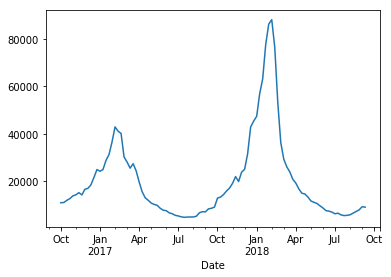

In [33]:
cdc_df.plot()
plt.legend().set_visible(False)
plt.show()

## Twitter Data

## Google Trends Data

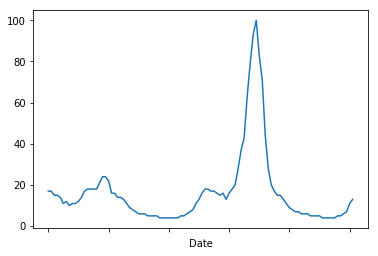

In [45]:
google_df.plot()
plt.legend().set_visible(False)
plt.show()

# Check for Autocorrelation

## CDC data

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 'pandas.tools.plotting.lag_plot' is deprecated, import 'pandas.plotting.lag_plot' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


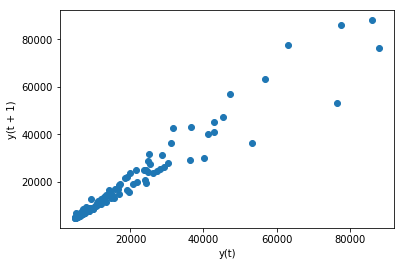

In [52]:
#plot the observation at the previous time step 
#(t-1) with the observation at the next time step (t+1) as a scatter plot.
#plots the visits(t) on the x-axis against 
#the visits on the previous day (t-1) on the y-axis.
lag_plot(cdc_df)
#clear correlation

### Pearson Correlation

In [90]:
# creates a lagged version of the dataset and calculates a 
#correlation matrix of each column with other columns, including itself.
values = cdc_df['ILITOTAL']
dataframe = concat([values.shift(2), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)
#strong positive correlation (0.89) between the observation and the lag=2 value.

          t-1       t+1
t-1  1.000000  0.892759
t+1  0.892759  1.000000


### Autocorrelation Plot

In [ ]:
#plot provides the lag number along the x-axis and the correlation coefficient value between -1 and 1 on the 
#y-axis. The plot also includes solid and dashed lines that indicate the 95% and 99% confidence interval for the 
#correlation values. Correlation values above these lines are more significant than those below the line, providing 
#a threshold or cutoff for selecting more relevant lag values.

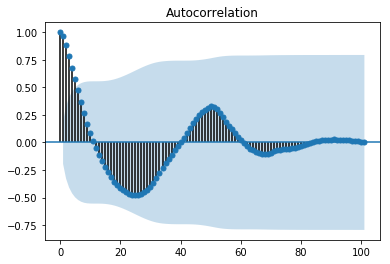

In [62]:
plot_acf(cdc_df)
plt.show()

# Autoregression

## Persistence Model: Naive Forecast
Predict the last 4 weeks of visits in the dataset given all prior observations. Persistence model: simplest model that we could use to make predictions by persisting the last observation. Provides a baseline of performance for the problem that we can use for comparison with an autoregression model. We can develop a test harness for the problem by splitting the observations into training and test sets, with only the last 7 observations in the dataset assigned to the test set as “unseen” data that we wish to predict.

The predictions are made using a walk-forward validation model so that we can persist the most recent observations for the next day. This means that we are not making a 4-week forecast, but 4 1-week forecasts.

Source: https://machinelearningmastery.com/persistence-time-series-forecasting-with-python/ 

Use two weeks ago value for this week

5827.0
6520.0
7227.0
7889.0
Test MSE: 1517.920


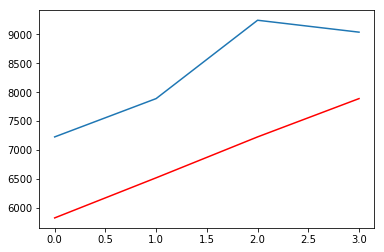

In [93]:
# create lagged dataset
values = cdc_df['ILITOTAL']
dataframe = concat([values.shift(2), values], axis=1)
dataframe.columns = ['t', 't+2']
# split into train and test sets
X = dataframe.values
train, test = X[1:len(X)-4], X[len(X)-4:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

# persistence model
def model_persistence(x):
    return x

# walk-forward validation
predictions = list()
for x in test_X:
    yhat = model_persistence(x)
    print(yhat)
    predictions.append(yhat)
test_score = np.sqrt(mean_squared_error(test_y, predictions))
print('Test RMSE: %.3f' % test_score)
# plot predictions vs expected
plt.plot(test_y)
plt.plot(predictions, color='red')
plt.show()

## Autoregression Model
An autoregression model is a linear regression model that uses lagged variables as input variables.

[10997 11926 12648 13790 14258 15160 14208 16605 16976 18463 21570 24900
 24178 24904 28759 31221 36510 42890 41098 40124 30183 28051 25484 27371
 24375 19684 15552 13012 11955 10763 10188  9809  8564  7757  7558  6636
  6264  5596  5326  4961  4764  4880  4899  4915  5230  6682  7133  7073
  8317  8566  9079 12873 13298 14364 15860 17095 19086 21932 19863 23796
 24996 31539 42822 45332 47345 56873 63181 77591 86207 88095 76482 53257
 36258 29253 26045 23899 20780 19162 16733 14911 14613 13316 11656 11093
 10606  9621  8699  7571  7371  6939  6258  6507  5788  5489  5593  5827
  6520]
[7227 7889 9243 9037]
Lag: 12
Coefficients: [ 1.38216696e+03  1.72387205e+00 -6.77892512e-01 -3.31974059e-01
  1.21484770e-01  3.31049797e-01 -1.47586737e-01 -1.93869590e-01
  2.71876903e-01 -3.86131161e-01  3.30801711e-01 -6.64921063e-03
 -1.02676432e-01]
predicted=7723.554837, expected=7227.000000
predicted=9240.027933, expected=7889.000000
predicted=11359.567155, expected=9243.000000
predicted=13296.60

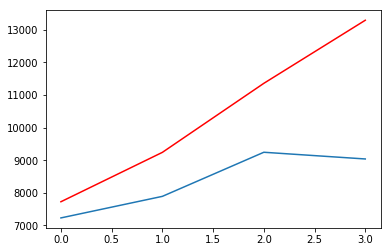

In [100]:
# split dataset
cdc_series = pd.Series(cdc_df['ILITOTAL'])
X = cdc_series.values
train, test = X[1:len(X)-4], X[len(X)-4:]
# train autoregression
model = AR(train)
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
    print('predicted=%f, expected=%f' % (predictions[i], test[i]))
error = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % error)
# plot results
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

# ARIMA